<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Carteiras-Investimentos-Com-Rebalanceamentos/blob/main/Otimiza%C3%A7%C3%A3o_de_Carteiras_de_Investimentos_com_Rebalanceamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
%%capture
!pip install lifelines

In [82]:
%%capture
!pip install -U pymoo

In [83]:
%%capture
!pip install seaborn

In [84]:
%%capture
!pip install optuna

In [105]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.termination import get_termination
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
from pymoo.indicators.hv import HV

In [86]:
# -----------------------------
# 1. GERAR DADOS FICTÍCIOS
# -----------------------------

np.random.seed(42)

ativos = [
    'PETR4', 'VALE3', 'ITUB4', 'BBDC4', 'BBAS3',
    'ABEV3', 'WEGE3', 'MGLU3', 'GGBR4', 'LREN3'
]

frailty_fatores = {ativo: round(np.random.uniform(0.7, 1.5), 2) for ativo in ativos}

dados_eventos = []
n = 100
lambda_base = 1.5
beta_base = 2.0

for ativo in ativos:
    frailty = frailty_fatores[ativo]
    tempos = np.random.weibull(beta_base, n) * lambda_base / frailty
    evento = np.random.binomial(1, 0.8, n)
    for t, e in zip(tempos, evento):
        dados_eventos.append({'Ativo': ativo, 'Tempo': t, 'Evento': e, 'Frailty': frailty})

df_eventos = pd.DataFrame(dados_eventos)

In [87]:
# -----------------------------
# 2. AJUSTE DO MODELO WEIBULL AFT COM FRAILTY VIA DUMMIES
# -----------------------------

df_model = pd.get_dummies(df_eventos[['Tempo', 'Evento', 'Ativo']], columns=['Ativo'], drop_first=True)

aft = WeibullAFTFitter()
aft.fit(df_model, duration_col='Tempo', event_col='Evento')

<lifelines.WeibullAFTFitter: fitted with 1000 total observations, 203 right-censored observations>

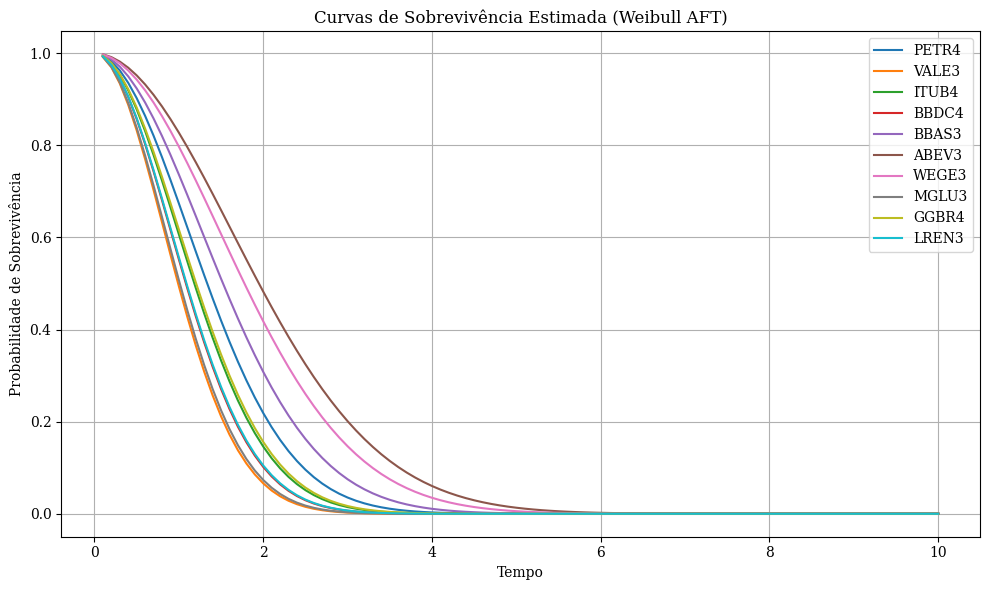

In [100]:
# -----------------------------
# 3. PLOTAR CURVAS DE SOBREVIVÊNCIA
# -----------------------------

fig, ax = plt.subplots(figsize=(10, 6))

for ativo in ativos:
    amostra = pd.DataFrame([0] * (len(df_model.columns) - 2), index=df_model.columns.drop(['Tempo', 'Evento'])).T
    if f'Ativo_{ativo}' in amostra.columns:
        amostra[f'Ativo_{ativo}'] = 1
    surv_func = aft.predict_survival_function(amostra, times=np.linspace(0.1, 10, 100))
    ax.plot(surv_func.index, surv_func.values.flatten(), label=ativo)

ax.set_title('Curvas de Sobrevivência Estimada (Weibull AFT)')
ax.set_xlabel('Tempo')
ax.set_ylabel('Probabilidade de Sobrevivência')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [89]:
# -----------------------------
# 4. OTIMIZAÇÃO BAYESIANA COM OPTUNA
# -----------------------------

def funcao_objetivo(trial):
    peso_ativos = np.array([trial.suggest_float(f"peso_{i}", 0.0, 1.0) for i in range(len(ativos))])
    peso_ativos /= peso_ativos.sum()  # Normalizar pesos

    retorno_esperado = np.sum(peso_ativos * np.random.uniform(0.05, 0.25, len(ativos)))
    risco = np.sqrt(np.dot(peso_ativos, peso_ativos.T)) * np.random.uniform(0.1, 0.3)
    custo_rebalanceamento = np.sum(np.abs(peso_ativos - 0.1)) * 0.01

    # Otimização (max retorno, min risco, min custo)
    score = retorno_esperado - risco - custo_rebalanceamento
    return -score  # Minimização

study = optuna.create_study(direction="minimize")
study.optimize(funcao_objetivo, n_trials=100)

print("\nMelhores pesos encontrados pela Otimização Bayesiana (Optuna):")
for i, ativo in enumerate(ativos):
    print(f"{ativo}: {study.best_params[f'peso_{i}']:.4f}")
print("Score final:", -study.best_value)

[I 2025-04-30 20:28:03,836] A new study created in memory with name: no-name-dbd348b3-5875-4f76-a217-d3c1952972dc
[I 2025-04-30 20:28:03,844] Trial 0 finished with value: -0.026494005198842235 and parameters: {'peso_0': 0.8208708965656978, 'peso_1': 0.6721701773140505, 'peso_2': 0.843948494662773, 'peso_3': 0.1855282286970028, 'peso_4': 0.42995542030957423, 'peso_5': 0.7459955165632034, 'peso_6': 0.7926749703114541, 'peso_7': 0.25508642808005655, 'peso_8': 0.762271657977069, 'peso_9': 0.9719589410514499}. Best is trial 0 with value: -0.026494005198842235.
[I 2025-04-30 20:28:03,847] Trial 1 finished with value: -0.07116398676617612 and parameters: {'peso_0': 0.15681900738647037, 'peso_1': 0.46649844428802634, 'peso_2': 0.8062147374192916, 'peso_3': 0.22845177695042707, 'peso_4': 0.08374425516558559, 'peso_5': 0.1336551143012744, 'peso_6': 0.9594302220459974, 'peso_7': 0.24107687711223902, 'peso_8': 0.35031044315740467, 'peso_9': 0.016566760179168916}. Best is trial 1 with value: -0.071


Melhores pesos encontrados pela Otimização Bayesiana (Optuna):
PETR4: 0.3124
VALE3: 0.1112
ITUB4: 0.0579
BBDC4: 0.4480
BBAS3: 0.5525
ABEV3: 0.9939
WEGE3: 0.7680
MGLU3: 0.6921
GGBR4: 0.6170
LREN3: 0.2125
Score final: 0.13169259668780592


In [90]:
# -----------------------------
# 5. OTIMIZAÇÃO MULTIOBJETIVO COM NSGA-II E MOPSO (via pymoo)
# -----------------------------

# Define o problema multiobjetivo
class CarteiraMultiObjetivo(Problem):
    def __init__(self):
        super().__init__(
            n_var=len(ativos),
            n_obj=3,
            n_constr=1,
            xl=0.0,
            xu=1.0
        )

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array(x)
        retorno = np.sum(x * np.random.uniform(0.05, 0.25, x.shape[1]), axis=1)
        risco = np.sqrt(np.sum((x ** 2), axis=1)) * 0.2
        custo = np.sum(np.abs(x - 0.1), axis=1) * 0.01

        out["F"] = np.column_stack([-retorno, risco, custo])
        out["G"] = np.sum(x, axis=1) - 1  # Soma dos pesos = 1

problem = CarteiraMultiObjetivo()

In [91]:
termination = get_termination("n_gen", 100)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.5369738938 |  4.0060459946 |             - |             -
     2 |      200 |      1 |  0.9963518117 |  3.0282809398 |             - |             -
     3 |      300 |      1 |  0.9963518117 |  2.3797186517 |             - |             -
     4 |      400 |      1 |  0.7038268979 |  1.8345485613 |             - |             -
     5 |      500 |      1 |  0.0493239651 |  1.3351104774 |             - |             -
     6 |      600 |      1 |  0.000000E+00 |  0.9020103386 |             - |             -
     7 |      700 |      6 |  0.000000E+00 |  0.5439391669 |  1.0000000000 |         ideal
     8 |      800 |      9 |  0.000000E+00 |  0.2534802527 |  0.3068132579 |         ideal
     9 |      900 |     16 |  0.000000E+00 |  0.0318799971 |  0.3350009622 |         ideal
    10 |     1000 |     23 |  0.000000E+00 |  0.000000E+00 |  0.3238751330 |         ideal

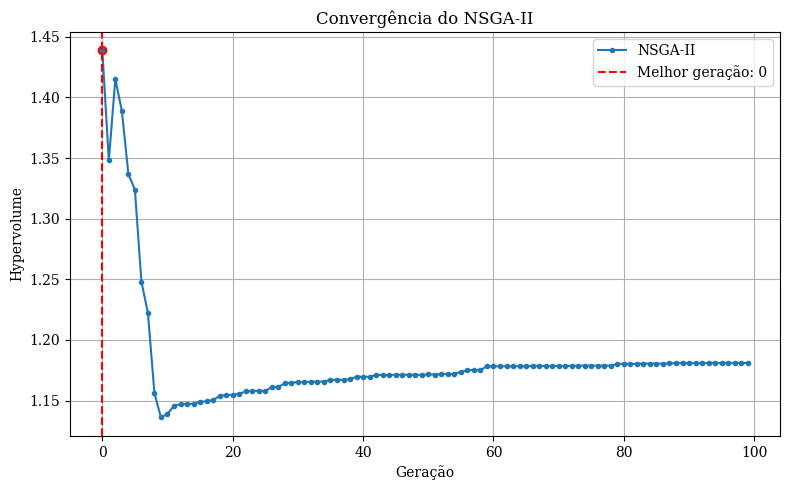

In [112]:
# -----------------------------
# Configurar algoritmo NSGA-II
# -----------------------------
algorithm_nsga2 = NSGA2(
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# -----------------------------
# Executar otimização
# -----------------------------
res_nsga2 = minimize(problem,
               algorithm_nsga2,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# Escolher um ponto de referência (ajuste conforme seus objetivos)
ref_point = np.array([1.0, 1.0, 1.0])

# Calcular HV por geração
hv = HV(ref_point=ref_point)
hv_values = []

for algo_gen in res_nsga2.history:
    F = algo_gen.pop.get("F")
    hv_values.append(hv.do(F))

# Encontrar a melhor geração
best_gen_idx = np.argmax(hv_values)
best_hv = hv_values[best_gen_idx]

# Plotar
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(hv_values)), hv_values, marker='.', label='NSGA-II')
plt.axvline(x=best_gen_idx, color='red', linestyle='--', label=f'Melhor geração: {best_gen_idx}')
plt.scatter(best_gen_idx, best_hv, color='red')
plt.title("Convergência do NSGA-II")
plt.xlabel("Geração")
plt.ylabel("Hypervolume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [93]:
# -------------------------------------
# NSGA-III
# -------------------------------------
ref_dirs_nsga3 = get_reference_directions("das-dennis", 3, n_partitions=12)
algorithm_nsga3 = NSGA3(
    ref_dirs=ref_dirs_nsga3,
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res_nsga3 = minimize(problem,
                     algorithm_nsga3,
                     termination,
                     seed=1,
                     save_history=True,
                     verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.5369738938 |  4.0060459946 |             - |             -
     2 |      200 |      1 |  0.9963518117 |  3.0282809398 |             - |             -
     3 |      300 |      1 |  0.9963518117 |  2.3797186517 |             - |             -
     4 |      400 |      1 |  0.7038268979 |  1.8345485613 |             - |             -
     5 |      500 |      1 |  0.0493239651 |  1.3351104774 |             - |             -
     6 |      600 |      1 |  0.000000E+00 |  0.9020103386 |             - |             -
     7 |      700 |      5 |  0.000000E+00 |  0.5439391669 |  1.2605673478 |         ideal
     8 |      800 |      8 |  0.000000E+00 |  0.2741015663 |  0.0263728309 |         ideal
     9 |      900 |     12 |  0.000000E+00 |  0.0490129189 |  0.4137573603 |         ideal
    10 |     1000 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0612383966 |         ideal

In [94]:
# -------------------------------------
# R-NSGA-II
# -------------------------------------
ref_points = np.array([[0.1], [-0.9], [0.05]]) # ponto de aspiração fictício, pode ajustar
algorithm_rnsga2 = RNSGA2(
    ref_points=ref_points,
    pop_size=100,
    epsilon=0.01,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res_rnsga2 = minimize(problem,
                      algorithm_rnsga2,
                      termination,
                      seed=1,
                      save_history=True,
                      verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.5369738938 |  4.0060459946 |             - |             -
     2 |      200 |      1 |  0.9963518117 |  3.0282809398 |             - |             -
     3 |      300 |      1 |  0.9963518117 |  2.3797186517 |             - |             -
     4 |      400 |      1 |  0.7038268979 |  1.8345485613 |             - |             -
     5 |      500 |      1 |  0.0493239651 |  1.3351104774 |             - |             -
     6 |      600 |      1 |  0.000000E+00 |  0.9020103386 |             - |             -
     7 |      700 |      6 |  0.000000E+00 |  0.5439391669 |  1.0000000000 |         ideal
     8 |      800 |      9 |  0.000000E+00 |  0.2534802527 |  0.3068132579 |         ideal
     9 |      900 |     16 |  0.000000E+00 |  0.0254117164 |  0.1103824975 |         ideal
    10 |     1000 |     30 |  0.000000E+00 |  0.000000E+00 |  0.2809448250 |         ideal

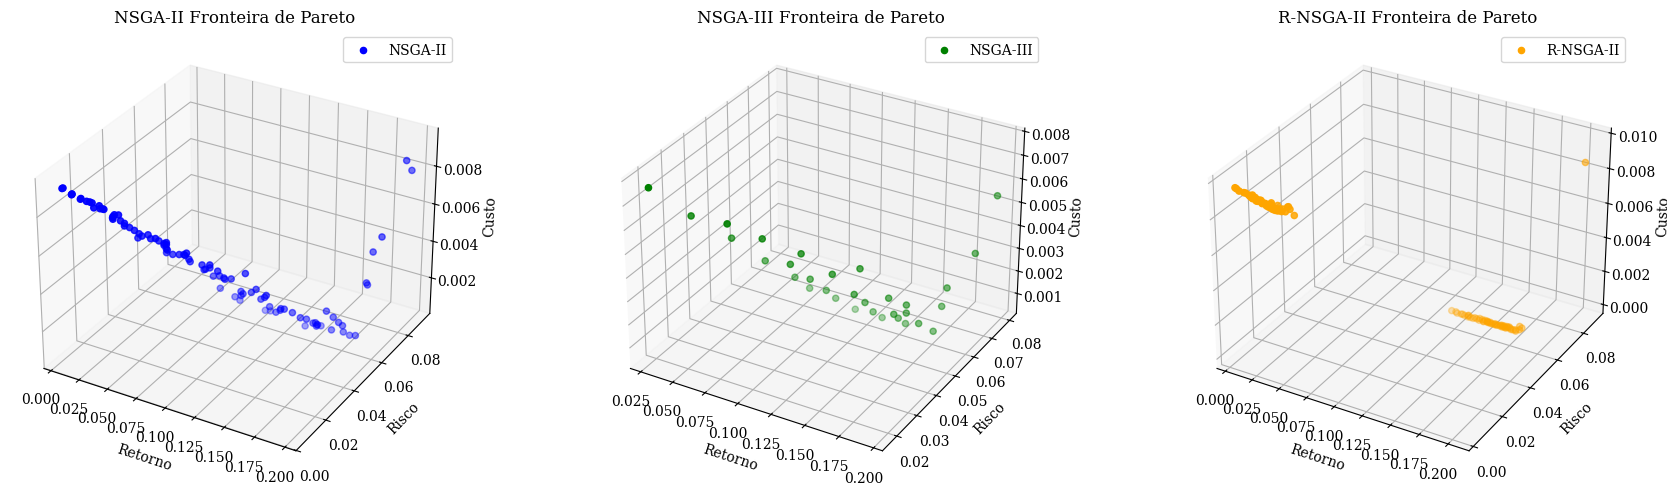

In [99]:
# -----------------------------
# 6. PLOTAR FRONTEIRA DE PARETO
# -----------------------------

fig = plt.figure(figsize=(18, 5))

# NSGA-II
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(-res_nsga2.F[:, 0], res_nsga2.F[:, 1], res_nsga2.F[:, 2], c='blue', label='NSGA-II')
ax1.set_title('NSGA-II Fronteira de Pareto')
ax1.set_xlabel('Retorno')
ax1.set_ylabel('Risco')
ax1.set_zlabel('Custo')
ax1.legend()

# NSGA-III
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(-res_nsga3.F[:, 0], res_nsga3.F[:, 1], res_nsga3.F[:, 2], c='green', label='NSGA-III')
ax2.set_title('NSGA-III Fronteira de Pareto')
ax2.set_xlabel('Retorno')
ax2.set_ylabel('Risco')
ax2.set_zlabel('Custo')
ax2.legend()

# R-NSGA-II
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(-res_rnsga2.F[:, 0], res_rnsga2.F[:, 1], res_rnsga2.F[:, 2], c='orange', label='R-NSGA-II')
ax3.set_title('R-NSGA-II Fronteira de Pareto')
ax3.set_xlabel('Retorno')
ax3.set_ylabel('Risco')
ax3.set_zlabel('Custo')
ax3.legend()

plt.tight_layout()
plt.show()